In [70]:
'''LIBRARIES'''
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'


from datetime import datetime, date
import yfinance as yf
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [60]:
priceScaler, volumeScaler = 0, 0

def ManualNorm(notnormList, pv):
    global priceScaler, volumeScaler
    outputList = notnormList
    maxValue = 0
    
    for i in notnormList:
        maxTmp = max(i)
        if maxTmp > maxValue:
            maxValue = maxTmp
            
    for lidx, l in enumerate(notnormList):
        for jidx, j in enumerate(l):
            outputList[lidx][jidx] = j/maxValue
            
    if pv == 0:
        priceScaler = maxValue
    elif pv == 1:
        volumeScaler = maxValue
    
    return outputList

def ManualDenorm(normList, pv):
    global priceScaler, volumeScaler
    outputList = normList

    if pv == 0:
        maxValue = priceScaler
    elif pv == 1:
        maxValue = volumeScaler
    
    for lidx, l in enumerate(normList):
        for jidx, j in enumerate(l):
            outputList[lidx][jidx] = j*maxValue
            
    return outputList


'''ohlcvValue: Index 0-Open, 1-High, 2-Low, 3-Close, 4-Volume'''
def getDataTarget(valuesListNormalized, numDaysForPrediction, numDaysPredicting, ohlcvValue):
    '''predicting based on numDaysForPrediction, predicting average for next numDaysPredicting'''
    step = numDaysForPrediction+numDaysPredicting
    step = 1
    '''targetWeek can be used for simulating sell later on'''
    targetWeek = []
    
    forPredictionFullLocal = []
    targetFullLocal = []
        
    for idx in range(0,(len(valuesListNormalized)-(numDaysForPrediction)-(numDaysPredicting)),step):
        #print(idx)
        '''making a list of numDaysForPrediction(20) from valuesListNormalized [1,2,3,..., 20] [2,3,4,...,21] ...'''
        forPredictionSingle = valuesListNormalized[idx:idx+numDaysForPrediction]
        forPredictionFullLocal += [forPredictionSingle]

        '''make a list of targets, average of next numDaysPredicting, for 0-20, getting 20-25'''
        targetRow = valuesListNormalized[idx+numDaysForPrediction:idx+numDaysForPrediction+numDaysPredicting]
        targetTotal = 0
        '''saving target week for later'''
        targetWeek+=[targetRow]
        
        for day in targetRow:
            targetTotal += day[ohlcvValue] # Index 0-Open, 1-High, 2-Low, 3-Close, 4-Volume
        targetFullLocal +=  [targetTotal/numDaysPredicting]

    return forPredictionFullLocal, targetFullLocal, targetWeek



def graphPrice(valuesList, valuesListNormalized, ema200):
    plt.plot([el[0:5] for el in valuesListNormalized])
    plt.show()

    
    return
    
def GetValuesListNormalized(ticker, period, interval):
    tickerDf = yf.download(tickers=ticker, period=period, interval=interval)
    ### '''getting data from dataframe'''
    dateIndexFrame=tickerDf.index

    '''turning all values to list'''
    valuesList = tickerDf.values.tolist()

    '''getting close values for EMA 200'''
    closeList = tickerDf["Close"]
    ema200 = closeList.ewm(span=200).mean().tolist()

    '''getting only prices (first 4 elements) / volumes (5th) for normaliztion'''
    priceList=[]
    for idx, el in enumerate(valuesList):
        x = el[0:4]
        x.append(ema200[idx])     #Adding EMA200
        priceList+=[x]

    volumeList = [[row[5]] for row in valuesList]
        
    '''normalizing with ^ functions'''
    priceListNormalized = ManualNorm(priceList,0) 
    
    volumeListNormalized = ManualNorm(volumeList,1)    

    '''recollecting prices/volume in one list '''
    valuesListNormalized = []

    '''valuesListNormalized - dataframe normalized'''
    for idx, pricesRow in enumerate(priceListNormalized):
        valuesRow = pricesRow
        valuesRow.append(volumeListNormalized[idx][0])
        valuesListNormalized+=[valuesRow]

    graphPrice(valuesList, valuesListNormalized, ema200)


        
    return valuesListNormalized

def PrepareTicker(ticker, period, interval):
    
    valuesListNormalized = GetValuesListNormalized(ticker, period, interval)
    
    '''to numpy array and splitting to train and test datasets, x_train - y_train, x_test - y_test'''
    forPredictionFull, targetFull, targetWeek = getDataTarget(valuesListNormalized, 20, 5, 3);

    data = np.array(forPredictionFull, dtype=float)
    target = np.array(targetFull,dtype=float)
    
    print (data.shape)
    print (target.shape)
    
    return data, target, targetWeek, priceScaler, volumeScaler






In [3]:
def PrepareModel():
    '''Setup model'''
    model=Sequential()
    '''layers'''
    model.add(LSTM((128), batch_input_shape=(None, None, 6),return_sequences=True))

    model.add(LSTM((64), batch_input_shape=(None, None, 6),return_sequences=True))

    model.add(LSTM((64), batch_input_shape=(None, None, 6),return_sequences=True))

    model.add(LSTM((32), batch_input_shape=(None, None, 6),return_sequences=True))

    model.add(LSTM((6), batch_input_shape=(None, None, 6)))

    model.add(Dense(1))

    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
    
    return model



In [4]:
def modelTest(history, x_test, y_test):
    global model 
    '''testing / predicitng'''
    predictionNormalized = model.predict(x_test)
    
    '''manual prediction inverse'''
    predictionInversed = ManualDenorm(predictionNormalized,0)

    '''manual target inverse'''
    targetInversed = ManualDenorm([[el] for el in y_test],0)

    '''prediciton / target scatter'''
    plt.scatter(range(len(predictionInversed)), predictionInversed , c='r')
    plt.scatter(range(len(targetInversed)), targetInversed, c='g')
    plt.show()

    '''loss graph'''
    plt.plot(history.history['loss'])
    plt.show()
    
    return predictionInversed, targetInversed



def tradeSimulation(predOnWeek, targetWeek, predictionInversed, targetInversed, verbose):
    
    '''getting close list to simulate buying on close the day before prediction week'''
    x_testPrices = [row[-1][0:4] for row in predOnWeek] #get last day before prediciton week, and strip volume from list
    #x_testInversed = priceScaler.inverse_transform(x_testPrices) #inverse normalization
    x_testInversed = ManualDenorm(x_testPrices,0) #inverse normalization
    x_testOnlyClose = [round(row[3],2) for row in x_testInversed] #get Close price of the day

    tooHighNum = 0
    tooLowNum = 0
    goodGuessNum = 0
    balanceTotal = 0
    balancePercTotal = 0
    
    realBalanceTotal = 0
    realBalancePercTotal = 0
    
    numTrades=0
    passiveTotal = 0
    
    for idx in range(len(x_testOnlyClose)):

        lastWeekClose = x_testOnlyClose[idx]
        weekPredictionAvg = round(predictionInversed[idx][0],2)
        weekActualAvg = round(targetInversed[idx][0],2)

        if weekPredictionAvg < weekActualAvg*0.99: tooLowNum+=1
        elif weekPredictionAvg > weekActualAvg*1.01: tooHighNum+=1
        else: goodGuessNum+=1
    
        '''calculating balance without ai interference'''   
        tradeTotal = round(weekActualAvg - lastWeekClose,2)
    
        targetWeekPrices = [day[0:4]for day in targetWeek[idx]]
        targetWeekPricesInversed = ManualDenorm(targetWeekPrices,0)
        closeWeekPrice = targetWeekPricesInversed[-1][3]
        passiveTotal+= round(closeWeekPrice - lastWeekClose,2)
        
        if verbose:
            print("\n\nLast Week Closed at ", lastWeekClose, "\t Week Closing at ",round(closeWeekPrice,2),"\t Passive Trade: ", round(passiveTotal,2))
        
        '''only buying those bot liked'''
        if lastWeekClose < weekPredictionAvg: #if next week looks good, we buy a stock and sell on predicted price (tradeTotal)
            '''selling on next week average price (we don't know it)'''
            numTrades+=1

            tradePercTotal = round((tradeTotal/lastWeekClose*100),2)
            balanceTotal+=tradeTotal
            balancePercTotal+=tradePercTotal

            if verbose:
                print("Avg Prediction: ", weekPredictionAvg, "    \tAvg Actual: ", weekActualAvg, "\tTrade Total: ", tradeTotal,"$\t", tradePercTotal,"%")

            
            '''selling on predicted price if reached, if not selling on week close'''
            
            gotPredicted=False;

            for num, day in enumerate(targetWeekPricesInversed):  
                maxDayPrice = day[1]
                if verbose:
                    print("Day", num+1,"Price: ",round(maxDayPrice,2))
                    
                if maxDayPrice > weekPredictionAvg:
                    if verbose:
                        print("Prediction reached. Selling at: ", weekPredictionAvg)
                    realTradeTotal = round(weekPredictionAvg - lastWeekClose,2)
                    gotPredicted=True
                    break;
            if not gotPredicted:
                closeWeekPrice = targetWeekPricesInversed[-1][3]
                if verbose:
                    print("Prediction not reached. Selling at: ", closeWeekPrice)
                realTradeTotal = round(closeWeekPrice - lastWeekClose,2)
         
            realTradePercTotal = round((realTradeTotal/lastWeekClose*100),2)
            realBalanceTotal+=realTradeTotal
            realBalancePercTotal+=realTradePercTotal
            if verbose:
                print("Real Trade Total: ", realTradeTotal,"$\t", realTradePercTotal,"%")


    if (numTrades==0):
        numTrades=-1

    print("\nTrades Made: ", numTrades)
    print("\nPassive Balance Total: \t", round(passiveTotal,2),"$")
    print("AI Balance Total: \t", round(balanceTotal,2), "$  \tAvg Trade Perc Change: ",round(balancePercTotal/numTrades,2),"%" )
    print("Real AI Balance Total: \t", round(realBalanceTotal,2), "$  \tAvg Trade Perc Change: ",round(realBalancePercTotal/numTrades,2),"%" )

    print("\ntooHighNum: ", tooHighNum, "\ntooLowNum: ",tooLowNum,"\ngoodGuessNum: ",goodGuessNum)



In [5]:
def Train(epochsNum, x_train, y_train, x_test, y_test):
    global model
    history = model.fit(x_train, y_train, verbose=2, epochs=epochsNum, validation_data=(x_test, y_test))
    return history
    
    
def TrainModel(epochsNum, data, target, targetWeek, randState=1, testSize=0.2):
    global model
    
    
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=testSize, random_state=randState)
    xTrainSim, xTestSim, yTrainSim, yTestSim = train_test_split(targetWeek, target, test_size=testSize, random_state=randState)

    history = Train(epochsNum, x_train, y_train, x_test, y_test)
    
    return history, x_test, y_test, xTestSim
      
        
def TestModel(history, x_test, y_test, xTestSim, verbose=False):
    
    predictionInversed, targetInversed = modelTest(history, x_test, y_test)
    tradeSimulation(x_test, xTestSim, predictionInversed, targetInversed, verbose)
      


[*********************100%***********************]  1 of 1 completed


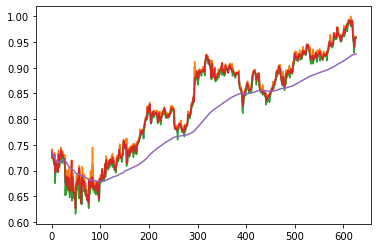

(602, 20, 6)
(602,)
Epoch 1/1000
10/10 - 3s - loss: 0.0225 - accuracy: 0.0000e+00 - val_loss: 0.0156 - val_accuracy: 0.0000e+00
Epoch 2/1000
10/10 - 1s - loss: 0.0128 - accuracy: 0.0000e+00 - val_loss: 0.0092 - val_accuracy: 0.0000e+00
Epoch 3/1000
10/10 - 1s - loss: 0.0086 - accuracy: 0.0000e+00 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 4/1000
10/10 - 1s - loss: 0.0075 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 5/1000
10/10 - 1s - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0128 - val_accuracy: 0.0000e+00
Epoch 6/1000
10/10 - 1s - loss: 0.0098 - accuracy: 0.0000e+00 - val_loss: 0.0120 - val_accuracy: 0.0000e+00
Epoch 7/1000
10/10 - 1s - loss: 0.0081 - accuracy: 0.0000e+00 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 8/1000
10/10 - 1s - loss: 0.0074 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 9/1000
10/10 - 1s - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 10

10/10 - 1s - loss: 0.0062 - accuracy: 0.0000e+00 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 77/1000
10/10 - 1s - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0138 - val_accuracy: 0.0000e+00
Epoch 78/1000
10/10 - 1s - loss: 0.0094 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 79/1000
10/10 - 1s - loss: 0.0075 - accuracy: 0.0000e+00 - val_loss: 0.0092 - val_accuracy: 0.0000e+00
Epoch 80/1000
10/10 - 1s - loss: 0.0071 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 81/1000
10/10 - 1s - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 82/1000
10/10 - 1s - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 83/1000
10/10 - 1s - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0093 - val_accuracy: 0.0000e+00
Epoch 84/1000
10/10 - 1s - loss: 0.0086 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_accuracy: 0.0000e+00
Epoch 85/1000
10/10 - 1s - loss: 

Epoch 151/1000
10/10 - 1s - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 152/1000
10/10 - 1s - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0093 - val_accuracy: 0.0000e+00
Epoch 153/1000
10/10 - 1s - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 154/1000
10/10 - 1s - loss: 0.0074 - accuracy: 0.0000e+00 - val_loss: 0.0090 - val_accuracy: 0.0000e+00
Epoch 155/1000
10/10 - 1s - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 156/1000
10/10 - 1s - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 157/1000
10/10 - 1s - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 158/1000
10/10 - 1s - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 159/1000
10/10 - 1s - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 160/

Epoch 226/1000
10/10 - 1s - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 227/1000
10/10 - 1s - loss: 0.0066 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 228/1000
10/10 - 1s - loss: 0.0066 - accuracy: 0.0000e+00 - val_loss: 0.0103 - val_accuracy: 0.0000e+00
Epoch 229/1000
10/10 - 1s - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 230/1000
10/10 - 1s - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 231/1000
10/10 - 1s - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0101 - val_accuracy: 0.0000e+00
Epoch 232/1000
10/10 - 1s - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 233/1000
10/10 - 1s - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 234/1000
10/10 - 1s - loss: 0.0082 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 0.0000e+00
Epoch 235/

Epoch 301/1000
10/10 - 1s - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 302/1000
10/10 - 1s - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 303/1000
10/10 - 1s - loss: 0.0078 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 304/1000
10/10 - 1s - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 305/1000
10/10 - 1s - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 306/1000
10/10 - 1s - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 307/1000
10/10 - 1s - loss: 0.0095 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 308/1000
10/10 - 1s - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 309/1000
10/10 - 1s - loss: 0.0073 - accuracy: 0.0000e+00 - val_loss: 0.0112 - val_accuracy: 0.0000e+00
Epoch 310/

Epoch 376/1000
10/10 - 1s - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 377/1000
10/10 - 1s - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 378/1000
10/10 - 1s - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 379/1000
10/10 - 1s - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 380/1000
10/10 - 1s - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 381/1000
10/10 - 1s - loss: 0.0060 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 382/1000
10/10 - 1s - loss: 0.0059 - accuracy: 0.0000e+00 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 383/1000
10/10 - 1s - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 384/1000
10/10 - 1s - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 385/

Epoch 451/1000
10/10 - 1s - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 452/1000
10/10 - 1s - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0068 - val_accuracy: 0.0000e+00
Epoch 453/1000
10/10 - 1s - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 454/1000
10/10 - 1s - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0071 - val_accuracy: 0.0000e+00
Epoch 455/1000
10/10 - 1s - loss: 0.0062 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 456/1000
10/10 - 1s - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 457/1000
10/10 - 1s - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 458/1000
10/10 - 1s - loss: 0.0051 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 459/1000
10/10 - 1s - loss: 0.0055 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 460/

Epoch 526/1000
10/10 - 1s - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 527/1000
10/10 - 1s - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 528/1000
10/10 - 1s - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 529/1000
10/10 - 1s - loss: 0.0051 - accuracy: 0.0000e+00 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 530/1000
10/10 - 1s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 531/1000
10/10 - 1s - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 532/1000
10/10 - 1s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 533/1000
10/10 - 1s - loss: 0.0060 - accuracy: 0.0000e+00 - val_loss: 0.0068 - val_accuracy: 0.0000e+00
Epoch 534/1000
10/10 - 1s - loss: 0.0053 - accuracy: 0.0000e+00 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 535/

Epoch 601/1000
10/10 - 1s - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 602/1000
10/10 - 1s - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 603/1000
10/10 - 1s - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 604/1000
10/10 - 1s - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 605/1000
10/10 - 1s - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0071 - val_accuracy: 0.0000e+00
Epoch 606/1000
10/10 - 1s - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0068 - val_accuracy: 0.0000e+00
Epoch 607/1000
10/10 - 1s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 608/1000
10/10 - 1s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 609/1000
10/10 - 1s - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 610/

Epoch 676/1000
10/10 - 1s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 677/1000
10/10 - 1s - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0090 - val_accuracy: 0.0000e+00
Epoch 678/1000
10/10 - 1s - loss: 0.0073 - accuracy: 0.0000e+00 - val_loss: 0.0095 - val_accuracy: 0.0000e+00
Epoch 679/1000
10/10 - 1s - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 680/1000
10/10 - 1s - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 681/1000
10/10 - 1s - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 682/1000
10/10 - 1s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 683/1000
10/10 - 1s - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 684/1000
10/10 - 1s - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 685/

Epoch 751/1000
10/10 - 1s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 752/1000
10/10 - 1s - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 753/1000
10/10 - 1s - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 754/1000
10/10 - 1s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 755/1000
10/10 - 1s - loss: 0.0058 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 756/1000
10/10 - 1s - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 757/1000
10/10 - 1s - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 758/1000
10/10 - 1s - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.0000e+00
Epoch 759/1000
10/10 - 1s - loss: 0.0040 - accuracy: 0.0000e+00 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 760/

Epoch 826/1000
10/10 - 1s - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 827/1000
10/10 - 1s - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0071 - val_accuracy: 0.0000e+00
Epoch 828/1000
10/10 - 1s - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0059 - val_accuracy: 0.0000e+00
Epoch 829/1000
10/10 - 1s - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 830/1000
10/10 - 1s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 831/1000
10/10 - 1s - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 832/1000
10/10 - 1s - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0063 - val_accuracy: 0.0000e+00
Epoch 833/1000
10/10 - 1s - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 834/1000
10/10 - 1s - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 835/

Epoch 901/1000
10/10 - 1s - loss: 0.0040 - accuracy: 0.0000e+00 - val_loss: 0.0063 - val_accuracy: 0.0000e+00
Epoch 902/1000
10/10 - 1s - loss: 0.0055 - accuracy: 0.0000e+00 - val_loss: 0.0095 - val_accuracy: 0.0000e+00
Epoch 903/1000
10/10 - 1s - loss: 0.0055 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 904/1000
10/10 - 1s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 905/1000
10/10 - 1s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.0000e+00
Epoch 906/1000
10/10 - 1s - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 907/1000
10/10 - 1s - loss: 0.0036 - accuracy: 0.0000e+00 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 908/1000
10/10 - 1s - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 909/1000
10/10 - 1s - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 910/

Epoch 976/1000
10/10 - 1s - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 977/1000
10/10 - 1s - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0071 - val_accuracy: 0.0000e+00
Epoch 978/1000
10/10 - 1s - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 979/1000
10/10 - 1s - loss: 0.0037 - accuracy: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.0000e+00
Epoch 980/1000
10/10 - 1s - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 981/1000
10/10 - 1s - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 982/1000
10/10 - 1s - loss: 0.0036 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 983/1000
10/10 - 1s - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 984/1000
10/10 - 1s - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 985/

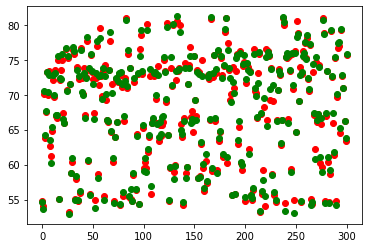

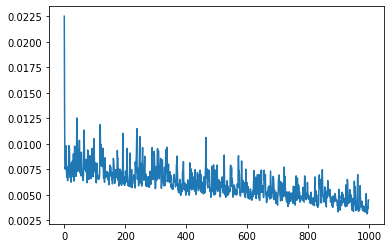


Trades Made:  160

Passive Balance Total: 	 46.54 $
AI Balance Total: 	 83.51 $  	Avg Trade Perc Change:  0.8 %
Real AI Balance Total: 	 60.06 $  	Avg Trade Perc Change:  0.59 %

tooHighNum:  38 
tooLowNum:  34 
goodGuessNum:  229
INFO:tensorflow:Assets written to: Models/ATVI_1000ep_90d_1h_EWA/assets
[*********************100%***********************]  1 of 1 completed


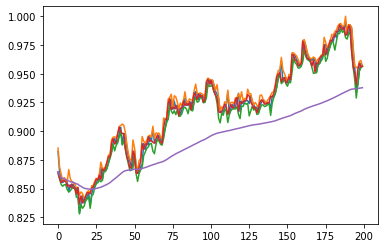



------
ATVI| Next 5 hour average prediction:  [77.78359]


In [73]:
#model = PrepareModel()

def Main():
    global model
    tickers="ATVI"
    epochs=1000
    period="90d"
    interval="1h"
    
    data, target, targetWeek, priceScaler, volumeScaler = PrepareTicker(tickers, period, interval)
   
    history, x_test, y_test, xTestSim = TrainModel(epochs, data, target, targetWeek, testSize=0.5, randState=10)
    TestModel(history, x_test, y_test, xTestSim)
    
    model.save('Models/'+tickers+"_"+str(epochs)+"ep_"+period+"_"+interval+"_EWA")

Main()


def PredNextWeek(ticker, period="20h", interval="1h"):
    if int(period[:-1]) < 200:
        period = str("200"+interval[-1:])
    
    valuesListNormalized = [GetValuesListNormalized(ticker, period,interval)[-20:]]
    '''testing / predicitng'''
    #print(valuesListNormalized)
    predictionNormalized = model.predict(valuesListNormalized)
    '''manual prediction inverse'''
    predictionInversed = ManualDenorm(predictionNormalized,0)
    return predictionInversed

print("\n\n------\nATVI| Next 5 hour average prediction: ", PredNextWeek("ATVI")[0])

          
def LoadModel():
    global model
    model = load_model('Models/ATVI_1000ep_90d_1h_EWA')

#LoadModel()
